## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb 

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice. 
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

# Transformer-based pretrained Language Model: RoBERTa


In [22]:
pip install simpletransformers --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries
import pandas as pd
import gensim
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn 
import nltk 
from nltk.stem import WordNetLemmatizer 
from sklearn import svm

In [6]:
from sklearn.datasets import fetch_20newsgroups

# load only a sub-selection of the categories (4 in our case)
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'sci.space'] 

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, random_state=42)

In [7]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [8]:
test = pd.DataFrame({'text': newsgroups_test.data, 'labels': newsgroups_test.target})

In [9]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=0, 
                               stratify=train[['labels']])

In [28]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model 
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=32 # batch size
model_args.learning_rate=4e-6 # learning rate
model_args.max_seq_length=256 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase. 
# For educational purposes, we set max_seq_len to 256.

# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)

In [29]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=4, args=model_args, use_cuda=False) # CUDA is enabled

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
_, history = model.train_model(train, eval_df=dev) 

  0%|          | 0/4 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

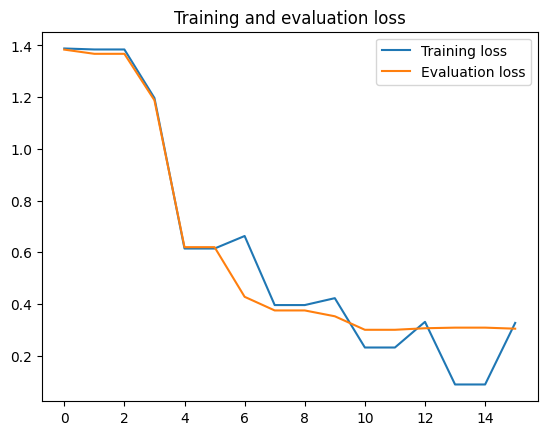

In [37]:
# Training and evaluation loss
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [38]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1it [00:03,  3.53s/it]
Running Evaluation: 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]


{'mcc': 0.8355903639998141, 'eval_loss': 0.30389564236005145}

In [33]:
#Make predictions with the model (predict the labels of the documents in the test set)
predicted, probabilities = model.predict(test.text.to_list())
test['predicted'] = predicted

  0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 

In [34]:
#test set predictions
test.head()

,text,labels,predicted
0,\nAnd guess who's here in your place.\n\nPleas...,1,1
1,Does anyone know if any of Currier and Ives et...,1,1
2,=FLAME ON\n=\n=Reading through the posts about...,2,0
3,\nBut in this case I said I hoped that BCCI wa...,0,0
4,\nIn the kind I have made I used a Lite sour c...,2,2


In [35]:
# Result (note: your result can be different due to randomness in operations)
print(classification_report(test['labels'], test['predicted']))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       319
           1       0.81      0.94      0.87       389
           2       0.91      0.87      0.89       396
           3       0.88      0.79      0.83       394

    accuracy                           0.86      1498
   macro avg       0.86      0.85      0.85      1498
weighted avg       0.86      0.86      0.86      1498



# Conventional Machine Learning Approach: SVM

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

# Text Preprocessing
lemmatizer = WordNetLemmatizer()
def lemmatize_stemming(text):
    return lemmatizer.lemmatize(text)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)  # Convert list of tokens back to string

# Apply preprocessing
train["processed_text"] = train["text"].map(preprocess)
test["processed_text"] = test["text"].map(preprocess)

# Convert text to BoW features using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train["processed_text"])
X_test = vectorizer.transform(test["processed_text"])

# Get labels
y_train = train["labels"]
y_test = test["labels"]

# Train SVM classifier
lin_clf = LinearSVC()
lin_clf.fit(X_train, y_train)

# Evaluate on test set
y_test_pred = lin_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       319
           1       0.72      0.83      0.77       389
           2       0.80      0.72      0.75       396
           3       0.70      0.74      0.72       394

    accuracy                           0.74      1498
   macro avg       0.74      0.73      0.74      1498
weighted avg       0.74      0.74      0.74      1498



/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Comparison

## Classification Report: BERT Model

![Scherm­afbeelding 2025-03-16 om 11.59.20.png](<attachment:Scherm­afbeelding 2025-03-16 om 11.59.20.png>)
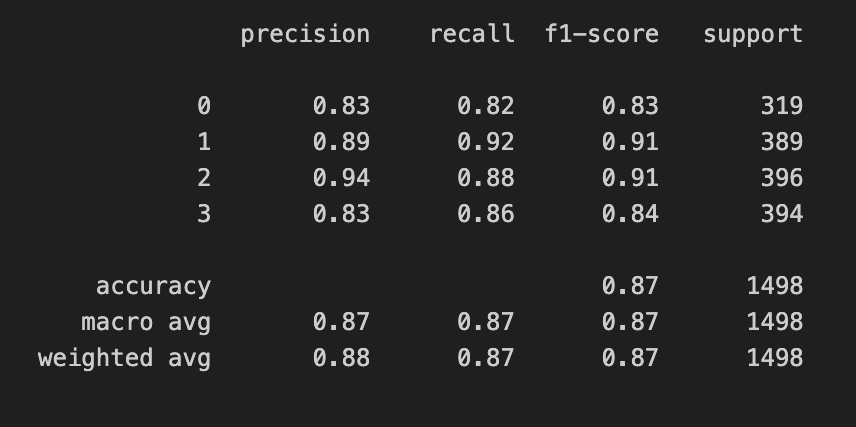

## Classification Report: RoBERTa Model

![Scherm­afbeelding 2025-03-16 om 12.02.02.png](<attachment:Scherm­afbeelding 2025-03-16 om 12.02.02.png>)
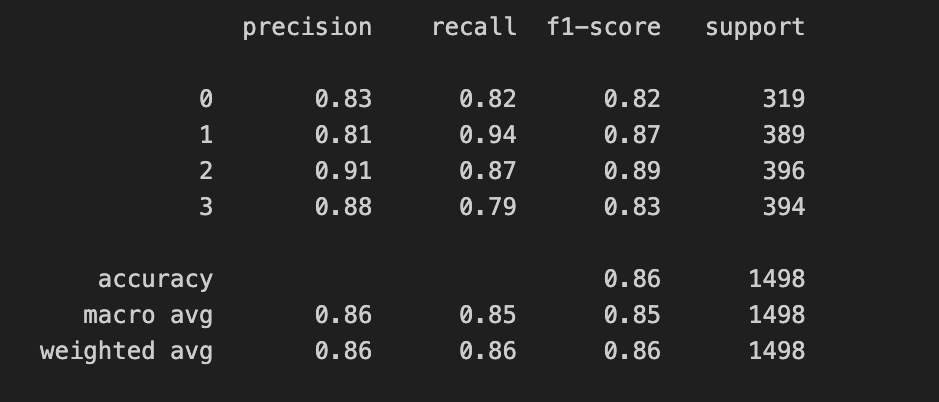

## Classification Report: SVM with BoW 

![Scherm­afbeelding 2025-03-16 om 12.03.31.png](<attachment:Scherm­afbeelding 2025-03-16 om 12.03.31.png>)
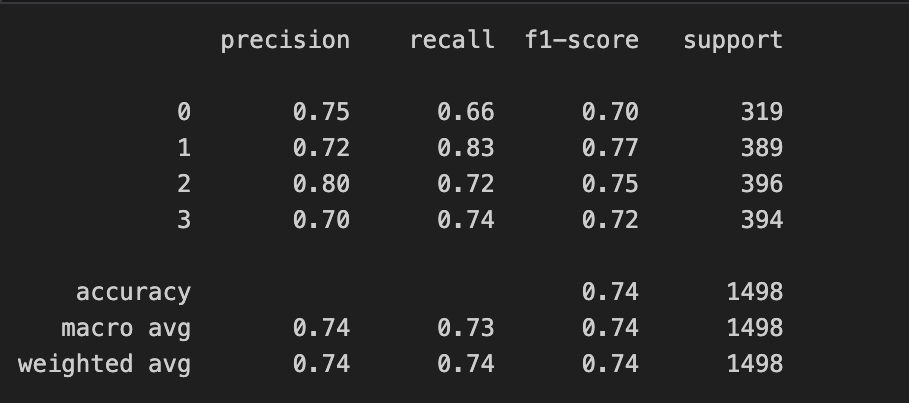

## Comparison between the 3 models 
